# Prediccion del resultado de eventos musicales


Se cuenta con un conjunto de 360 eventos realizados el mes de abril en Estados Unidos. Para cada uno de estos eventos se cuenta con el resultado de éstos, a través del número de tickets y el porcentaje de ocupación del lugar del evento. Es este indicador, el porcentaje, el valor que constituirá la variable dependiente del problema.

Para analizar el problema, se buscó contar con un conjunto de variables independientes, que permitieran caracterizar al evento. En primer lugar, se tomaron datos del evento:
    * estado de EEUU
    * día de la semana
    * capacidad del recinto

Por otro lado, se realizó la recopilación de datos de redes sociales, accediendo a las APIs de las redes, para cada uno de los artistas del conjunto. Se comenzó con la recopilación de las redes (los nombres) para cada artista. Posteriormente, se hizo la captura de datos, de manera automática.

Las redes accedidas fueron:
    * Facebook : likes en la pagina del artista
    * Youtube : suscriptores del canal
    * Instagram : followers, likes
    * Spotify : followers, popularidad
    * Twitter : followers, menciones en USA, menciones mundo

Además, se realizó la captura en días distintos (una semana de diferencia), obteniendo un indicador de crecimiento para algunas de las cifras. Estas son:
    * likes de facebook
    * followers de instagram
    * followers de twitter

El resultado de esto fue la construcción de un vector de 15 componentes, con los datos de las redes sociales (variables independientes) junto a los datos de los eventos.

Con esta información se procedió a construir un modelo de regresión, que permitiera predecir el porcentaje de éxito de cada evento. Para ello se implementó un programa en Python que toma el conjunto de vectores construído, y construye un modelo para analizar la data.


In [215]:
import pandas as pd
import numpy as np
import sys

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import seaborn as sns
import sklearn_pandas as sp
from sklearn.model_selection import cross_val_score, cross_val_predict
import warnings
warnings.filterwarnings('ignore')

algorithm = 'randomforest'
threshold = 77

In [217]:
# modelos de regresion
models = {}
models['linearreg']    = LinearRegression()
models['svr']          = SVR(kernel='rbf', C=1.0, gamma='auto', degree=2)
models['knn']          = KNeighborsRegressor()
models['ridge']        = Ridge(alpha=[0.001])
models['lasso']        = Lasso()
models['elasticnet']   = ElasticNet()
models['dectree']      = DecisionTreeRegressor(max_features=0.1, criterion='friedman_mse', random_state=3)
models['randomforest'] = RandomForestRegressor(n_estimators=400, criterion='mse', max_depth=None, min_samples_split=1, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=4, random_state=None, verbose=0)
models['adaboost']     = AdaBoostRegressor()
models['gradient']     = GradientBoostingRegressor()

En primer lugar se realiza la carga de datos, separando los conjuntos de entrenamiento y test, y extrayendo la variable dependiente (values). Se determinó utilizar una separación del conjunto de datos, destinando un 10% de la muestra para test, y el 90% restante para entrenamiento. 

En esta etapa fue posible probar el modelo utilizando sólo algunas de las variables, comparando el resultado de su ejecución. Finalmente, se decidió utilizar todas las variables disponibles.


In [244]:
# carga de datos y seleccion de variables
dataset = pd.read_csv('http://www.danielgomez.cl/tmp/rrss_new_filtrado.csv')
print "count: " + str(dataset['tickets'].count())
print "mean: " + str(dataset['tickets'].mean())
print "std: " + str(dataset['tickets'].std())
#dataset = dataset.replace(np.NaN, 0)
total = len(dataset)
size = int(0.90 * total)
mapper = sp.DataFrameMapper([
    ('state', LabelBinarizer()),
    ('dayofweek', LabelBinarizer()),
    (['price', 'capacity', 'facebook_likes', 'youtube_suscrs',
    'instagram_folls', 'instagram_likes', 'spotify_folls', 'spotify_pop',
    'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
     'facebook_crec', 'instagram_crec', 'twitter_crec'], StandardScaler())
    ])
X = dataset[['state', 'dayofweek', 'capacity', 'price',
        'facebook_likes', 'youtube_suscrs',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
        'facebook_crec', 'instagram_crec', 'twitter_crec']]
Xy = dataset[['state', 'dayofweek', 'capacity', 'price',
        'facebook_likes', 'youtube_suscrs',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
        'facebook_crec', 'instagram_crec', 'twitter_crec', 'tickets']]
X = mapper.fit_transform(X) # numpy.ndarray
y = dataset['tickets'] # dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

count: 360
mean: 81.125
std: 23.73797159120012


# Analisis de variables

A continuación se realiza el análisis de las variables, graficando la relación entre cada par de variables. También, se grafica la relación de cada variable con la variable dependiente ("tickets").
<BR>
Este análisis permite revisar el nivel de correlación de cada variable respecto al valor a predecir.

In [220]:
Xy[0:20]

,state,dayofweek,capacity,facebook_likes,youtube_suscrs,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,instagram_crec,twitter_crec,tickets
0,MA,7,953,10274954,287123737,7300000,536800,3029243,81,12699509,108,27,-0.062,0.000,0.158,100
1,IN,3,1417,762373,113736876,122600,43792,161105,59,91464,100,29,0.185,0.571,0.021,98
2,LA,5,1300,454703,21199358,219500,21029,93882,60,140624,100,59,0.159,0.137,0.031,40
3,CA,6,10000,454703,21199358,219500,21029,93882,60,140624,100,59,0.159,0.137,0.031,100
4,WI,5,1042,215616,4005073,90100,4165,1193,14,533143,100,47,0.003,0.333,-0.042,73
5,NY,4,450,47495,17292,18200,5627,6255,37,67301,100,11,0.084,0.549,0.260,25
6,NV,5,244,31915,90035,1324,377,15020,40,1169,33,3,-0.019,0.378,0.000,100
7,MT,3,1425,3653615,5309730,1200000,96300,1548813,72,1867218,112,45,-0.060,0.000,-0.068,72
8,NV,5,3364,1654182,488910476,273500,52700,163,0,528265,100,11,-0.006,0.402,-0.036,64
9,CA,2,425,96103,12140493,65400,28728,148732,62,28223,100,58,0.147,1.225,0.223,100


In [245]:
Xy.describe().round(decimals=2)

,dayofweek,capacity,price,facebook_likes,youtube_suscrs,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,instagram_crec,twitter_crec,tickets
count,360.00,360.00,360.00,360.00,3.600000e+02,360.00,360.00,360.00,360.00,360.00,360.00,360.00,360.00,360.00,360.00,360.00
mean,4.60,2601.33,47.88,2581906.56,4.427922e+07,2165355.42,110915.37,614796.46,52.70,1990527.46,456.04,201.39,0.09,0.60,0.25,81.12
std,1.61,4831.86,42.99,6917112.22,1.535232e+08,9260745.56,399477.49,1508460.05,19.27,8537012.86,2502.91,1262.64,0.54,0.88,0.80,23.74
min,1.00,100.00,7.10,1563.00,0.000000e+00,258.00,0.00,3.00,0.00,42.00,0.00,0.00,-7.39,-1.17,-2.79,5.00
25%,4.00,468.75,20.00,47044.00,9.840675e+04,11925.00,1862.00,17302.00,42.00,10056.50,97.00,13.50,-0.03,0.09,-0.01,64.00
50%,5.00,1150.00,37.50,260592.50,1.333448e+06,64300.00,10128.50,85286.00,55.00,54237.00,100.00,41.50,0.00,0.36,0.07,92.50
75%,6.00,2498.50,57.25,1751068.25,1.343300e+07,343975.00,35271.00,523637.00,66.00,419010.00,195.00,117.00,0.10,0.84,0.24,100.00
max,7.00,55292.00,478.50,44727137.00,1.640133e+09,75100000.00,4286600.00,9450508.00,94.00,66068104.00,38919.00,22184.00,4.05,9.09,10.34,100.00


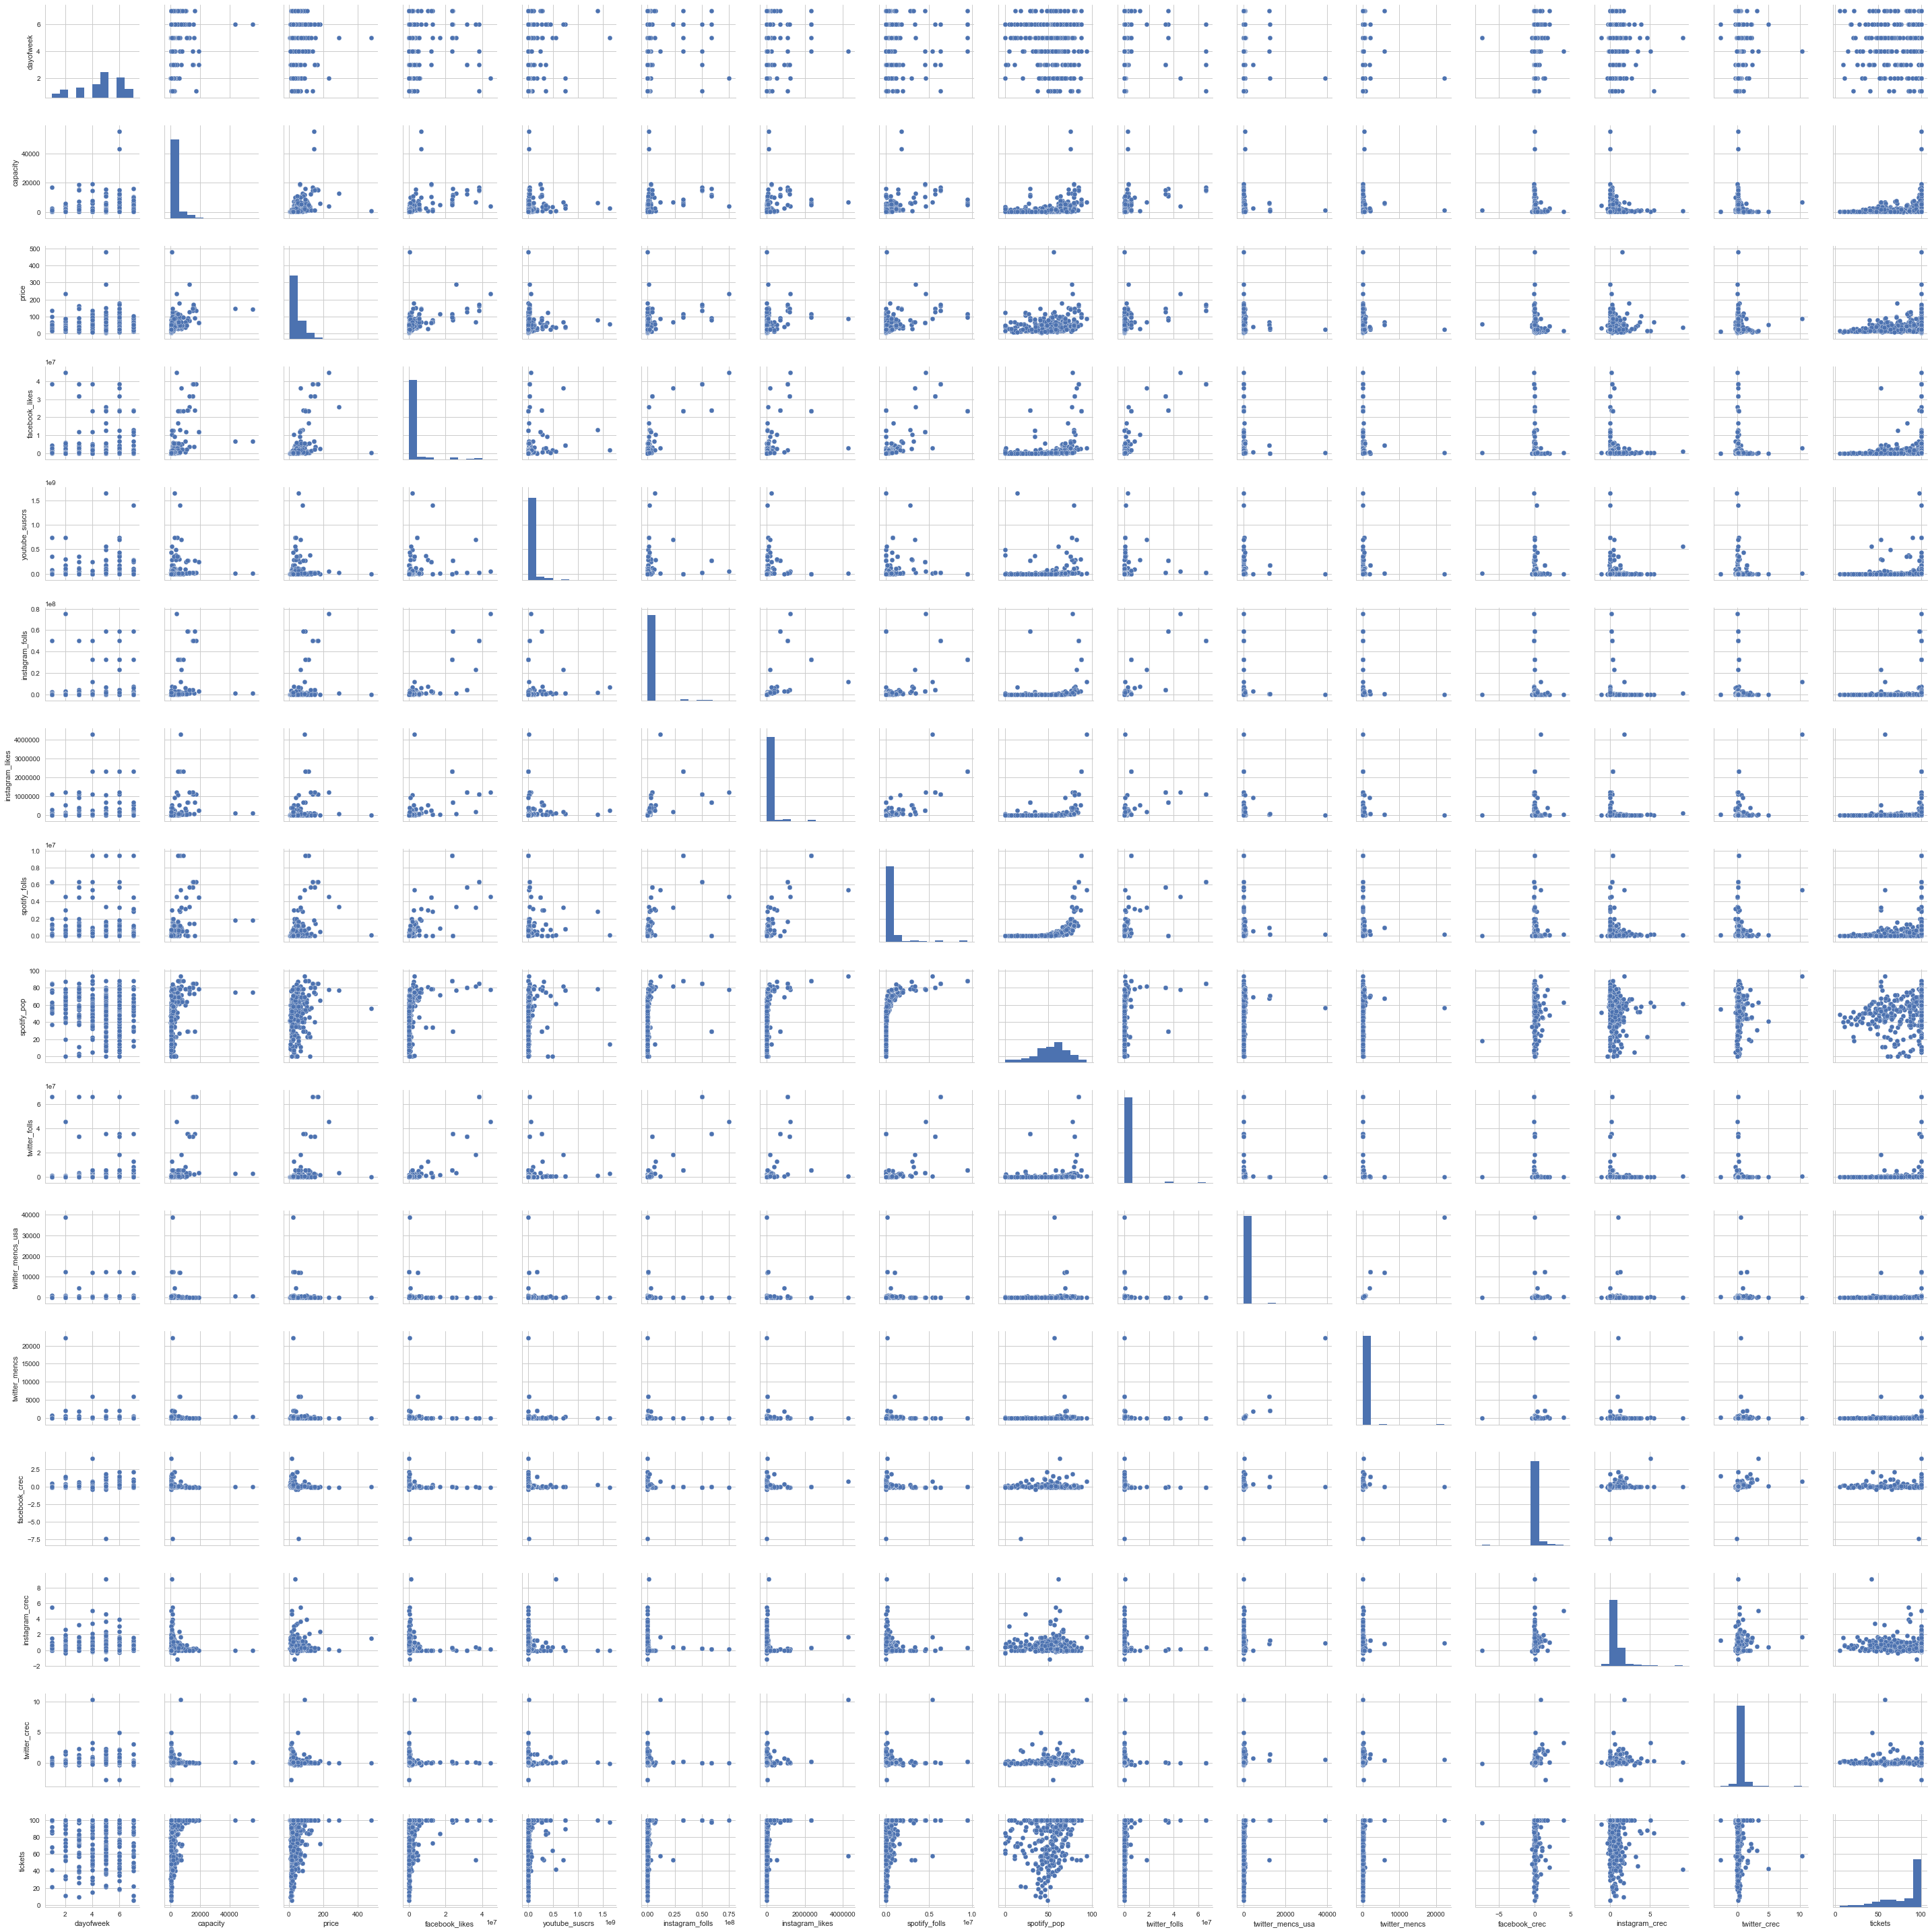

In [248]:
# grafico de variables
data_df = pd.DataFrame(Xy, columns=['dayofweek', 'capacity', 'price', 'facebook_likes','youtube_suscrs','instagram_folls','instagram_likes','spotify_folls','spotify_pop','twitter_folls','twitter_mencs_usa','twitter_mencs', 'facebook_crec', 'instagram_crec', 'twitter_crec', 'tickets'])
sns.set(style='whitegrid', context='notebook')
features_plot = data_df.columns
data_df[0:10]
sns.pairplot(data_df)#, size=2.0);
plt.tight_layout()

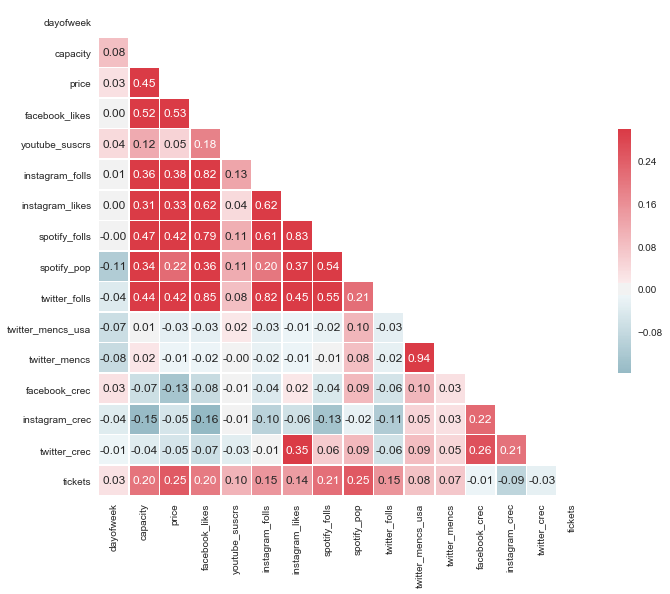

In [249]:
# correlacion entre variables
corr_vectors = Xy.corr()
mask = np.zeros_like(corr_vectors, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_vectors, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

En base a la observacion de las variables, se puede apreciar que hay variables que estan poco correlacionadas con la venta de tickets. En particular, esto sucede con: <i>dayofweek, youtube_suscrs, twitter_mencs_usa, twitter_mencs, facebook_crec, instagram_crec</i> y <i>twitter_crec</i>, con una correlacion inferior al 10%.

# Modelo de regresion

A continuación se realiza el entrenamiento del modelo. Luego de probar con diversos algoritmos, se decidió utilizar <I>RandomForestRegressor</I>.

El modelo es entrenado con el conjunto de entrenamiento, y a continuación, se realiza la predicción utilizando el conjunto de test.

In [237]:
# implementacion modelo
model = models[algorithm]
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = cross_val_predict(model, X, y, cv=6)

Lo siguiente es analizar el resultado de la predicción. En primer lugar, se implementó una medida del resultado considerando una categorización en clases de los datos y el resultado, considerando un umbral para el valor de la variable dependiente. En este caso, se determinó que los valores mayores o iguales a 77% serían considerados un <b>resultado positivo</b>, y valores menores, un <b>resultado negativo</b>.

De esta manera, el sistema realiza el conteo de casos satisfactoriamente predichos, entregando un score de <B><I>accuracy</I></B>.
    
También, se calcula el coeficiente de determinación, $R^2$.

In [238]:
# calculo de errores y aciertos
sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
errores_positivo = 0; errores_negativo = 0
sum_positivo = 0; sum_negativo = 0
sum_predict_positivo = 0; sum_predict_negativo = 0
total_test = len(X_test)
total_test = len(X)
y_list = list(y)
for k in range(0, len(predictions)):
    sum += abs(predictions[k] - y_list[k])
    if y_list[k] >= threshold and predictions[k] >= threshold:
        aciertos_positivo += 1
    if y_list[k] >= threshold and predictions[k] < threshold:
        errores_positivo += 1
    if y_list[k] < threshold and predictions[k] < threshold:
        aciertos_negativo += 1
    if y_list[k] < threshold and predictions[k] >= threshold:
        errores_negativo += 1
    if y_list[k] >= threshold:
        sum_positivo += 1
    else:
        sum_negativo += 1
    if predictions[k] >= threshold:
        sum_predict_positivo += 1
    else:
        sum_predict_negativo += 1

In [239]:
# estadisticas del modelo
print
print "R2: " + str(round(r2_score(y_list, predictions), 2))
print "RMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2))
print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
print "PRECISION: " + str(round(1.0 * aciertos_positivo / sum_predict_positivo, 3))
print "RECALL: " + str(round(1.0 * aciertos_positivo / sum_positivo, 3))
df = pd.DataFrame({'real': y_list, 'prediction': predictions})
print "correlacion: " + str(round(df.corr()['real'][0], 2))
print "confusion-matrix:"
conf = pd.DataFrame([[aciertos_positivo, errores_positivo], [errores_negativo, aciertos_negativo]], columns=['positivo', 'negativo'])
conf.rename(index={0:'positivo', 1:'negativo'})


R2: 0.14
RMSE: 22.0
SCORE: 239 / 360 = 0.664
PRECISION: 0.75
RECALL: 0.728
correlacion: 0.38
confusion-matrix:


,positivo,negativo
positivo,171,64
negativo,57,68


Respecto a la predicción, se grafica su resultado, donde se muestran los valores reales versus las predicciones. En este gráfico se puede apreciar que el cuadrante superior-derecha muestra los casos positivos correctamente clasificados, lo mismo con el cuadrante inferior-izquierda, para los casos negativos. El resto de los casos son los erroneamente clasificados.

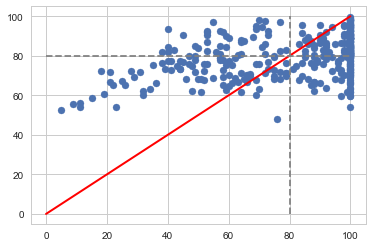

In [227]:
# grafico de dispersion de las predicciones
plt.scatter(y_list, predictions)
plt.plot([0, 100], [0, 100], c='r', lw=2)
ax = plt.gca()
line_h = mlines.Line2D([0,100], [80, 80], color='gray', ls='dashed')
line_v = mlines.Line2D([80,80], [0,100], color='gray', ls='dashed')
ax.add_line(line_h)
ax.add_line(line_v)
plt.show()

# Ajuste del modelo: reduccion dimensional

En base al analisis de variables realizado, se determina que se eliminaran las siguientes variables:
- dayofweek
- youtube_suscrs
- twitter_mencs_usa
- twitter_mencs
- facebook_crec
- instagram_crec
- twitter_crec

Ahora, el dataset es mas reducido, y se procede a entrenar un nuevo modelo para ver sus resultados.

In [268]:
# carga de datos y seleccion de variables
mapper = sp.DataFrameMapper([
    ('state', LabelBinarizer()),
    (['capacity', 'facebook_likes',
    'instagram_folls', 'instagram_likes', 'spotify_folls', 'spotify_pop',
    'twitter_folls'], StandardScaler())
    ])
X = dataset[['state', 'capacity',
        'facebook_likes',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls']]
X = mapper.fit_transform(X)
y = dataset['tickets']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
pd.DataFrame(y_test).head()

,tickets
209,92
220,79
276,100
320,72
175,100


In [269]:
# implementacion modeo
model = models[algorithm]
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = cross_val_predict(model, X, y, cv=6)

In [270]:
# calculo de errores y aciertos
sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
errores_positivo = 0; errores_negativo = 0
sum_positivo = 0; sum_negativo = 0
sum_predict_positivo = 0; sum_predict_negativo = 0
total_test = len(X_test)
total_test = len(X)
y_list = list(y)
for k in range(0, len(predictions)):
    sum += abs(predictions[k] - y_list[k])
    if y_list[k] >= threshold and predictions[k] >= threshold:
        aciertos_positivo += 1
    if y_list[k] >= threshold and predictions[k] < threshold:
        errores_positivo += 1
    if y_list[k] < threshold and predictions[k] < threshold:
        aciertos_negativo += 1
    if y_list[k] < threshold and predictions[k] >= threshold:
        errores_negativo += 1
    if y_list[k] >= threshold:
        sum_positivo += 1
    else:
        sum_negativo += 1
    if predictions[k] >= threshold:
        sum_predict_positivo += 1
    else:
        sum_predict_negativo += 1

In [271]:
# estadisticas del modelo
print
print "R2: " + str(round(r2_score(y_list, predictions), 2))
print "RMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2))
print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
print "PRECISION: " + str(round(1.0 * aciertos_positivo / sum_predict_positivo, 3))
print "RECALL: " + str(round(1.0 * aciertos_positivo / sum_positivo, 3))
df = pd.DataFrame({'real': y_list, 'prediction': predictions})
print "correlacion: " + str(round(df.corr()['real'][0], 2))
print "confusion-matrix:"
conf = pd.DataFrame([[aciertos_positivo, errores_positivo], [errores_negativo, aciertos_negativo]], columns=['positivo', 'negativo'])
conf.rename(index={0:'positivo', 1:'negativo'})


R2: 0.15
RMSE: 21.89
SCORE: 257 / 360 = 0.714
PRECISION: 0.787
RECALL: 0.77
correlacion: 0.4
confusion-matrix:


,positivo,negativo
positivo,181,54
negativo,49,76


El modelo arroja ahora un 72% de accuracy, lo que representa un mejor resultado.

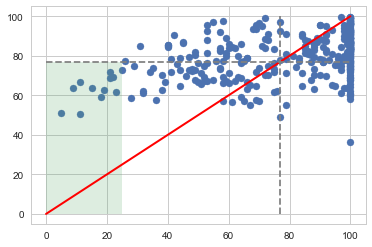

In [254]:
# grafico de dispersion de las predicciones
plt.scatter(y_list, predictions)
plt.plot([0, 100], [0, 100], c='r', lw=2)
ax = plt.gca()
line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
ax.add_line(line_h)
ax.add_line(line_v)
x0 = [0, 0, 25, 25]
y0 = [0, threshold, threshold, 0]
ax.fill(x0, y0, alpha=0.2)
plt.show()

In [243]:
# despliegue como clases
df = pd.DataFrame(y)
df.insert(loc=1, column='predictions', value=predictions.round(0))
y_label = y.copy()
y_label[y>=threshold] = 'positivo'
y_label[y<threshold] = 'negativo'

predictions_label = pd.Series(predictions)
predictions_label[predictions_label>=threshold] = 'positivo'
predictions_label[predictions_label<threshold] = 'negativo'

df1 = pd.DataFrame(y_label)
df1.insert(loc=1, column='predictions', value=predictions_label)

df.insert(loc=2, column='tickets-class', value=df1['tickets'].tolist())
df.insert(loc=3, column='predictions-class', value=df1['predictions'].tolist())
df.head()

,tickets,predictions,tickets-class,predictions-class
0,100,92.0,positivo,positivo
1,98,87.0,positivo,positivo
2,40,93.0,negativo,positivo
3,100,90.0,positivo,positivo
4,73,94.0,negativo,positivo
